# Binary Classification
This is a multi-class single-label dataset. 
* I start with a simply binary classification problem: cyberbullying tweets vs. not cyberbullying tweets. In order to do so I used various **classification models**. 

* Finally, I tried to show an explanation of Logistic Regression model for an arbitrary instance in the test set, generated using the **LIME package**.

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from stop_words import get_stop_words

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix


from sklearn.model_selection import learning_curve

#LIME
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer




In [2]:
# stop_words = get_stop_words('english')
# stop_words.extend(['', 're', 'rt', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's', 'b',
#                   'aren', 'can', 'couldn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'mustn', 'shan', 'shouldn', 
#                    'wasn', 'weren', 'won', 'wouldn'])

In [3]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [4]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

## Import dataset and data preparation
* "not_cyberbullying": 0
* "religion": 1 
* "age": 2 
* "gender": 3 
* "ethnicity": 4

In [5]:
# df_test = pd.read_csv('test_set.csv')
# df_test = df_test.drop(columns=['Unnamed: 0'])
# df_test["Type"].replace("not_cyberbullying", "not_c", inplace=True)

In [6]:
# df_test.head()

In [7]:
df = pd.read_csv('Data/cleaned_tweet.csv')
df = df.drop(columns=['Unnamed: 0'])

C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


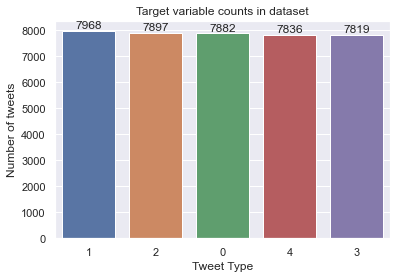

In [8]:
unique= df["Type"].unique()
freq = df["Type"].value_counts()
sns.set(font_scale = 1)

ax = sns.countplot(df["Type"], 
                   order = df["Type"].value_counts().index)
plt.title("Target variable counts in dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

# adding the text labels
rects = ax.patches
for rect, label in zip(rects, freq):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [9]:
df = df.dropna()

In [10]:
#merge all cyberbullying tweets category in two binaries categories
#0: not cyberbullying 1:cyberbullying
df.loc[df.Type != 0,'Type'] = 1

In [11]:
(unique, counts) = np.unique(df['Type'], return_counts=True)

print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)

Unique values of the target variable [0 1]
Counts of the target variable : [ 7881 31520]


C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


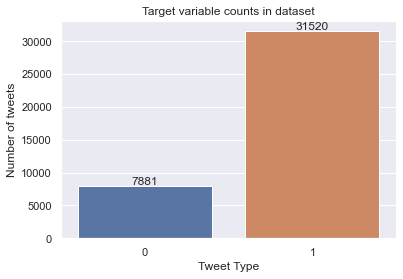

In [12]:
sns.set(font_scale = 1)

ax = sns.barplot(unique, counts)
plt.title("Target variable counts in dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [13]:
text_len = []
for text in df.Tweet:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [14]:
df['text_len'] = text_len

In [15]:
df

,Tweet,cat_Type,Type,text_clean,Tweet_tokenized,tokenized_bigram,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,word katandandre food crapilicious mkr,"['word', 'katandandre', 'food', 'crapilicious'...","[('word', 'katandandre'), ('katandandre', 'foo...",9
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,aussietv white mkr theblock today sunrise stud...,"['aussietv', 'white', 'mkr', 'theblock', 'toda...","[('aussietv', 'white'), ('white', 'mkr'), ('mk...",14
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classy whore red velvet cupcake,"['classy', 'whore', 'red', 'velvet', 'cupcake']","[('classy', 'whore'), ('whore', 'red'), ('red'...",9
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,jasongio meh thanks head concern another angry...,"['jasongio', 'meh', 'thanks', 'head', 'concern...","[('jasongio', 'meh'), ('meh', 'thanks'), ('tha...",18
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,rudhoeenglish isis account pretend kurdish acc...,"['rudhoeenglish', 'isis', 'account', 'pretend'...","[('rudhoeenglish', 'isis'), ('isis', 'account'...",18
...,...,...,...,...,...,...,...
39397,"Black ppl aren't expected to do anything, depe...",ethnicity,1,black arent expect anything depend anything ye...,"['black', 'arent', 'expect', 'anything', 'depe...","[('black', 'arent'), ('arent', 'expect'), ('ex...",42
39398,Turner did not withhold his disappointment. Tu...,ethnicity,1,turner withhold turner call court abominable c...,"['turner', 'withhold', 'turner', 'call', 'cour...","[('turner', 'withhold'), ('withhold', 'turner'...",45
39399,I swear to God. This dumb nigger bitch. I have...,ethnicity,1,swear god dumb nigger bitch get bleach hair re...,"['swear', 'god', 'dumb', 'nigger', 'bitch', 'g...","[('swear', 'god'), ('god', 'dumb'), ('dumb', '...",20
39400,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1,yea fuck therealexel you be nigger fuck unfoll...,"['yea', 'fuck', 'therealexel', 'you', 'be', 'n...","[('yea', 'fuck'), ('fuck', 'therealexel'), ('t...",15


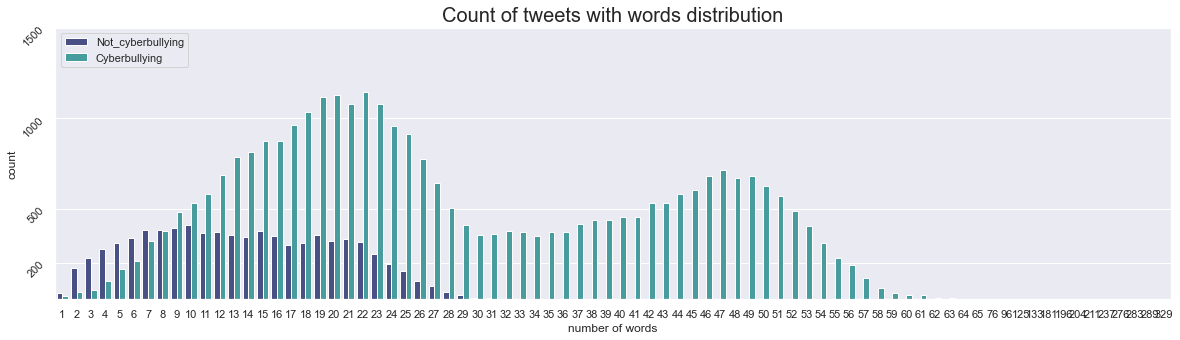

In [16]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<=1000], hue=df['Type'], palette='mako')
plt.title('Count of tweets with words distribution', fontsize=20)
plt.legend(['Not_cyberbullying', 'Cyberbullying'])
plt.yticks([200, 500, 1000, 1500], ['200','500', '1000', '1500'],rotation=45)
plt.ylabel('count')
plt.xlabel('number of words')
plt.show()

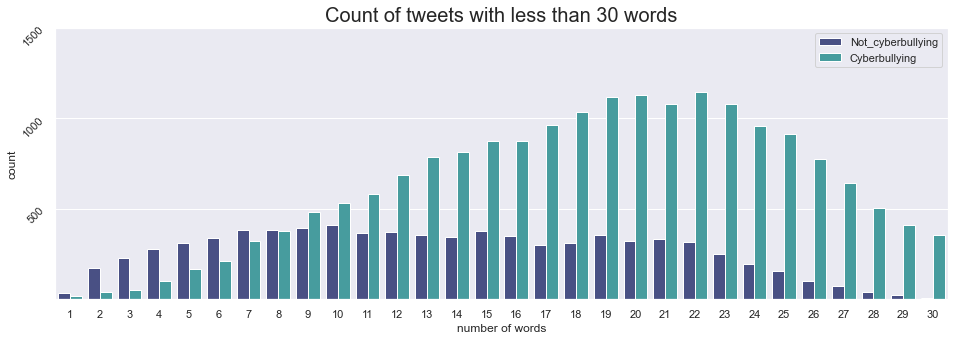

In [17]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<=30],hue=df['Type'], palette='mako')
plt.title('Count of tweets with less than 30 words', fontsize=20)
plt.legend(['Not_cyberbullying', 'Cyberbullying'])
plt.yticks([500, 1000, 1500], ['500', '1000', '1500'],rotation=45)
plt.ylabel('count')
plt.xlabel('number of words')
plt.show()

In [18]:
#I remove all the tweet with less than 7 words
df = df[df['text_len'] > 7]

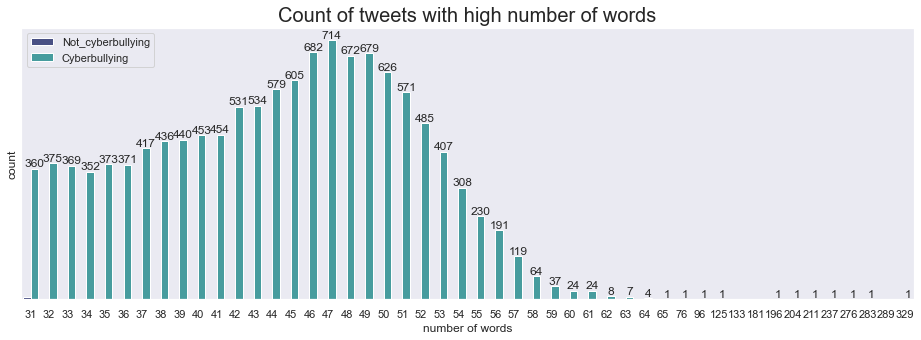

In [19]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>30)], hue=df['Type'], palette='mako')
plt.title('Count of tweets with high number of words', fontsize=20)
plt.legend(['Not_cyberbullying', 'Cyberbullying'])
plt.yticks([])
ax.bar_label(ax.containers[1])
plt.ylabel('count')
plt.xlabel('number of words')
plt.show()

In the above plot, there are only cyberbullying tweets because we restricted to just tweets composed by more than 30 words. It is immediate to see that there are not "not_cyberbullying" tweet in that range of words

In [20]:
#I remove tweet with more than 45 words
df = df[df['text_len'] < 45]

In [21]:
max_len = np.max(df['text_len'])
max_len

44

In [22]:
df.sort_values(by=["text_len"], ascending=False)

,Tweet,cat_Type,Type,text_clean,Tweet_tokenized,tokenized_bigram,text_len
16846,A @SMQureshiPTI @ImranKhanPTI Friendly advice ...,religion,1,smqureshipti imrankhanpti friendly advice good...,"['smqureshipti', 'imrankhanpti', 'friendly', '...","[('smqureshipti', 'imrankhanpti'), ('imrankhan...",44
30728,The same girls who bullied me for my Carrie Un...,age,1,girl bully carrie underwood standom middle sch...,"['girl', 'bully', 'carrie', 'underwood', 'stan...","[('girl', 'bully'), ('bully', 'carrie'), ('car...",44
31105,cheesy high school movie au where hawks is get...,age,1,cheesy high school movie au hawk get bully dab...,"['cheesy', 'high', 'school', 'movie', 'au', 'h...","[('cheesy', 'high'), ('high', 'school'), ('sch...",44
18013,FarRight Radical MAGADummies (Cherry Picking C...,religion,1,farright radical magadummies cherry pick repre...,"['farright', 'radical', 'magadummies', 'cherry...","[('farright', 'radical'), ('radical', 'magadum...",44
38946,hmmm..have to ask Was Kanye West PPP loan give...,ethnicity,1,hmmmhave ask kanye west ppp loan gi haven trum...,"['hmmmhave', 'ask', 'kanye', 'west', 'ppp', 'l...","[('hmmmhave', 'ask'), ('ask', 'kanye'), ('kany...",44
...,...,...,...,...,...,...,...
12609,praising the current in-ternship part of the sys,gender,1,praise current internship part sys,"['praise', 'current', 'internship', 'part', 's...","[('praise', 'current'), ('current', 'internshi...",8
12699,"Well, this is what an anti-feminist looks like.",gender,1,well antifeminist look like,"['well', 'antifeminist', 'look', 'like']","[('well', 'antifeminist'), ('antifeminist', 'l...",8
12704,@HumanistFury @Femitheist ...good luck to you ...,gender,1,humanistfury femitheist good luck,"['humanistfury', 'femitheist', 'good', 'luck']","[('humanistfury', 'femitheist'), ('femitheist'...",8
3474,@athenahollow @ShadowPraxis i'm married with k...,not_cyberbullying,0,athenahollow shadowpraxis marry kid also,"['athenahollow', 'shadowpraxis', 'marry', 'kid...","[('athenahollow', 'shadowpraxis'), ('shadowpra...",8


C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


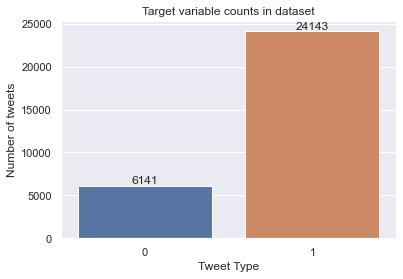

In [23]:
(unique, counts) = np.unique(df['Type'], return_counts=True)

sns.set(font_scale = 1)

ax = sns.barplot(unique, counts)
plt.title("Target variable counts in dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

## Dataset split

In [24]:
data = 'Tweet_tokenized'
target = 'Type'
X_train, X_test, y_train, y_test = train_test_split(df[data], df[target], test_size=0.3, random_state=42)

In [25]:
print("x_train ->", len(X_train), "record")
print("x_test  ->", len(X_test), "record")
print("y_train ->", len(y_train), "record")
print("y_test  ->", len(y_test), "record")

x_train -> 21198 record
x_test  -> 9086 record
y_train -> 21198 record
y_test  -> 9086 record


In [26]:
y_train.value_counts()

1    16885
0     4313
Name: Type, dtype: int64

## Class balancing

In [27]:
#oversampling 
ros = RandomOverSampler(sampling_strategy=0.4)
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['Tweet_tokenized', 'Type'])
X_train = train_os['Tweet_tokenized'].values
y_train = train_os['Type'].values

In [28]:
#undersampling 
rus = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = rus.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['Tweet_tokenized', 'Type'])
X_train = train_os['Tweet_tokenized'].values
y_train = train_os['Type'].values

In [29]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6754],
       [   1, 6754]], dtype=int64)

C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


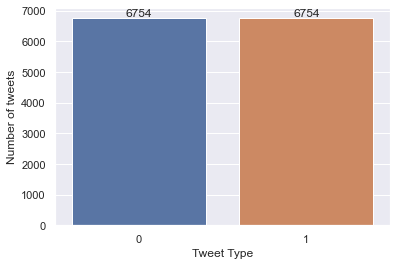

In [30]:
sns.set(font_scale = 1)

ax = sns.barplot(unique, counts)
#plt.title("Target variable counts in balanced dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

## Tokenization

In [31]:
X_train

array(["['thompson', 'school', 'district', 'new', 'website', 'support', 'community', 'deal', 'bully', 'cyberbullying', 'check']",
       "['ashleylynch', 'oo', 'thats', 'appreciate', 'greatly', 'go', 'release', 'financial', 'info', 'soon']",
       "['yes', 'midget', 'kick', 'mefelt', 'like', 'bulldozer', 'shove']",
       ...,
       "['blewishsky', 'chelseaarosee', 'trix', 'dumb', 'nigger', 'fuck']",
       "['heard', 'white', 'supremacist', 'ku', 'klux', 'klan', 'christian', 'radical', 'group', 'million', 'support', 'base', 'islam', 'alone', 'single']",
       "['samhuz', 'ghostbusters', 'remake', 'woman', 'take', 'role', 'ghoul', 'slay', 'saviour', 'sexist', 'let', 'stupid', 'eh']"],
      dtype=object)

In [32]:
vect = CountVectorizer()#min_df = 5)   # min_df: minimum number of words in a sentence
X_train_tok = vect.fit_transform(X_train)
X_test_tok =vect.transform(X_test)

In [33]:
len(vect.vocabulary_)

21390

In [34]:
vect.vocabulary_

{'thompson': 18955,
 'school': 16695,
 'district': 5158,
 'new': 12956,
 'website': 20492,
 'support': 18268,
 'community': 3698,
 'deal': 4595,
 'bully': 2605,
 'cyberbullying': 4380,
 'check': 3165,
 'ashleylynch': 1168,
 'oo': 13728,
 'thats': 18793,
 'appreciate': 1014,
 'greatly': 7693,
 'go': 7508,
 'release': 15847,
 'financial': 6686,
 'info': 9132,
 'soon': 17666,
 'yes': 21128,
 'midget': 12060,
 'kick': 10311,
 'mefelt': 11866,
 'like': 10974,
 'bulldozer': 2594,
 'shove': 17207,
 'star': 17923,
 'bowl': 2343,
 'curse': 4342,
 'leave': 10782,
 'engineering': 5872,
 'npo': 13357,
 'allow': 556,
 'purchase': 15275,
 'ridiculous': 16109,
 'thing': 18927,
 'corali': 3964,
 'havesey': 8144,
 'ptisalarkhan': 15215,
 'muslim': 12625,
 'anti': 874,
 'christianity': 3314,
 'fine': 6694,
 'jewish': 9769,
 'offense': 13562,
 'jihadwatchrs': 9812,
 'sqzruolp': 17858,
 'robert': 16198,
 'spencer': 17771,
 'pj': 14616,
 'medium': 11856,
 'holidays': 8456,
 'york': 21180,
 'public': 15223,

In [35]:
vect.get_feature_names()

C:\Users\Martina\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aaa',
 'aaaaaaaaaa',
 'aaaaaaaaaah',
 'aaaah',
 'aaaand',
 'aaah',
 'aaannndd',
 'aaawww',
 'aadcvgkjg',
 'aah',
 'aajaatay',
 'aalawofficial',
 'aalwuhaib',
 'aamattyhealy',
 'aampes',
 'aander',
 'aap',
 'aasmanikitaab',
 'aaua',
 'ab',
 'aba',
 'abadonaew',
 'abandon',
 'abandona',
 'abbott',
 'abbswinston',
 'abbu',
 'abbuse',
 'abby',
 'abc',
 'abcbreaking',
 'abccom',
 'abcny',
 'abcnycom',
 'abd',
 'abdi',
 'abdoshbag',
 'abduct',
 'abducted',
 'abdul',
 'abe',
 'abedhalawi',
 'abeed',
 'aberration',
 'abhe',
 'abhorrent',
 'abide',
 'abilities',
 'ability',
 'abis',
 'abiyahmedali',
 'able',
 'ableg',
 'ableist',
 'abo',
 'abolish',
 'abolishment',
 'abolition',
 'abolitionism',
 'abomination',
 'aboriginal',
 'abortion',
 'aboutfuck',
 'aboutoh',
 'abpoli',
 'abra',
 'abraham',
 'abrahamic',
 'abrirem',
 'abroad',
 'abroadfree',
 'abs',
 'absinthe',
 'absolute',
 'absolutely',
 'absolutley',
 'abstain',
 'abstractex',
 'absurd',
 'abt',
 'abualiis',
 'abubaraa',
 'abu

In [36]:
X_train_tok[0,:]

<1x21390 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [37]:
print(X_train_tok[0,:])

  (0, 18955)	1
  (0, 16695)	1
  (0, 5158)	1
  (0, 12956)	1
  (0, 20492)	1
  (0, 18268)	1
  (0, 3698)	1
  (0, 4595)	1
  (0, 2605)	1
  (0, 4380)	1
  (0, 3165)	1


In [38]:
vect.inverse_transform(X_train_tok[0,:])

[array(['thompson', 'school', 'district', 'new', 'website', 'support',
        'community', 'deal', 'bully', 'cyberbullying', 'check'],
       dtype='<U14')]

In [39]:
for feat,freq in zip(vect.inverse_transform(X_train_tok[0,:])[0],X_train_tok[0,:].data):
    print(feat,freq)

thompson 1
school 1
district 1
new 1
website 1
support 1
community 1
deal 1
bully 1
cyberbullying 1
check 1


## Feature selection
Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator
* SelectKBest removes all but takes the K highest scoring features

In [40]:
bin_sel = SelectKBest(chi2, k = 2000).fit(X_train_tok,y_train) 
X_train_sel_bin = bin_sel.transform(X_train_tok)
X_test_sel_bin = bin_sel.transform(X_test_tok)

In [41]:
bin_sel.get_support()

array([False, False, False, ..., False, False, False])

In [42]:
X_train_sel_bin

<13508x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 86582 stored elements in Compressed Sparse Row format>

In [43]:
X_train_sel_bin[0,:]

<1x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [44]:
print(X_train_sel_bin[0,:])

  (0, 214)	1
  (0, 302)	1
  (0, 372)	1
  (0, 1494)	1
  (0, 1672)	1
  (0, 1912)	1


In [45]:
print(vect.inverse_transform(bin_sel.inverse_transform(X_train_sel_bin[0,:])))

[array(['bully', 'community', 'cyberbullying', 'school', 'support',
       'website'], dtype='<U14')]


## Weigthing
Then we apply TF-IDF transformation to associate weights to the different words based on their frequency (rarer words will be given more importance).



In [46]:
tf_transformer_bin = TfidfTransformer(use_idf=True).fit(X_train_sel_bin)
X_train_tf_bin = tf_transformer_bin.transform(X_train_sel_bin)
X_test_tf_bin = tf_transformer_bin.transform(X_test_sel_bin)

In [47]:
print(X_train_tf_bin[0,:])

  (0, 1912)	0.5433805399951324
  (0, 1672)	0.33993961666982253
  (0, 1494)	0.20997416555253387
  (0, 372)	0.5696906171419306
  (0, 302)	0.4286358060121202
  (0, 214)	0.1918682936763549


In [48]:
for feat,weight,freq in zip(vect.inverse_transform(bin_sel.inverse_transform(X_train_tf_bin[0,:]))[0],X_train_tf_bin[0,:].data,X_train_sel_bin[0,:].data):
    print(feat,weight,freq)
    

bully 0.5433805399951324 1
community 0.33993961666982253 1
cyberbullying 0.20997416555253387 1
school 0.5696906171419306 1
support 0.4286358060121202 1
website 0.1918682936763549 1


# Classification algorithms 
* Naive Bayes
* SVM
* Logistic Regression
* Decision Tree
* Random Forest

## Naive Bayes

In [49]:
bin_nb_clf = MultinomialNB()
bin_nb_clf.fit(X_train_tf_bin, y_train)
bin_nb_pred = bin_nb_clf.predict(X_test_tf_bin)

In [50]:
print('Classification report:')
print(classification_report(y_test, bin_nb_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1828
           1       0.93      0.94      0.93      7258

    accuracy                           0.89      9086
   macro avg       0.83      0.82      0.83      9086
weighted avg       0.89      0.89      0.89      9086



In [51]:
bin_nb_scores = cross_val_score(bin_nb_clf, X_train_tf_bin, y_train, cv=10)

In [52]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (bin_nb_scores.mean(), bin_nb_scores.std()))

0.86 accuracy with a standard deviation of 0.02


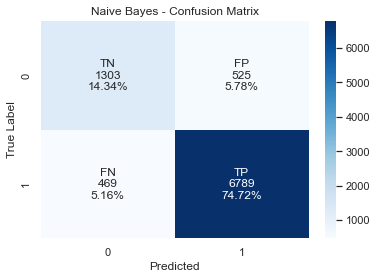

In [53]:
nb_cm = confusion_matrix(y_test, bin_nb_pred)
make_confusion_matrix(nb_cm, 'Naive Bayes - Confusion Matrix')

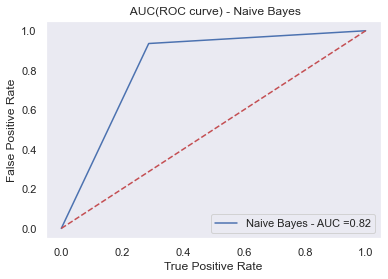

In [54]:
plot_roc_curve(y_test, bin_nb_pred, 'Naive Bayes')

## Linear SVC

In [55]:
bin_svm_clf = LinearSVC().fit(X_train_tf_bin, y_train)
bin_svm_pred = bin_svm_clf.predict(X_test_tf_bin)

In [56]:
print('Classification report:')
print(classification_report(y_test, bin_svm_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.79      1828
           1       0.97      0.90      0.94      7258

    accuracy                           0.90      9086
   macro avg       0.84      0.90      0.86      9086
weighted avg       0.92      0.90      0.91      9086



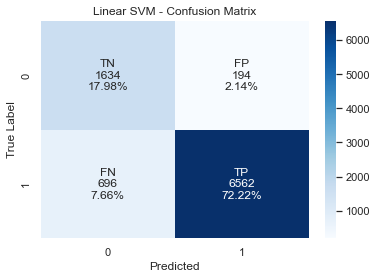

In [57]:
bin_svm_cm = confusion_matrix(y_test, bin_svm_pred)
make_confusion_matrix(bin_svm_cm, 'Linear SVM - Confusion Matrix')

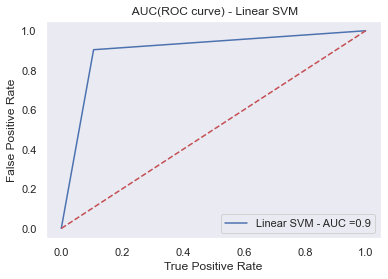

In [58]:
plot_roc_curve(y_test, bin_svm_pred, 'Linear SVM')

## Logistic Regression

In [59]:
bin_lr_clf = LogisticRegression(C = 0.5, solver = "sag").fit(X_train_tf_bin, y_train) #solver as 'sag' has better performance with large dataset
bin_lr_pred = bin_lr_clf.predict(X_test_tf_bin)

print('Classification report:')
print(classification_report(y_test, bin_lr_pred))

bin_lr_scores = cross_val_score(bin_lr_clf, X_train_tf_bin, y_train, cv=10)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_lr_scores.mean(), bin_lr_scores.std()))

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      1828
           1       0.98      0.89      0.93      7258

    accuracy                           0.90      9086
   macro avg       0.83      0.90      0.85      9086
weighted avg       0.92      0.90      0.90      9086


 
0.90 accuracy with a standard deviation of 0.01


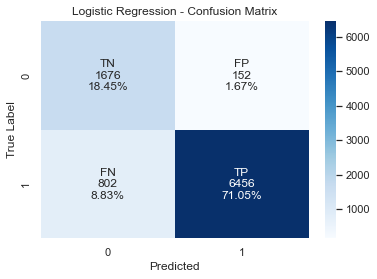

In [60]:
bin_lr_cm = confusion_matrix(y_test, bin_lr_pred)
make_confusion_matrix(bin_lr_cm, 'Logistic Regression - Confusion Matrix')

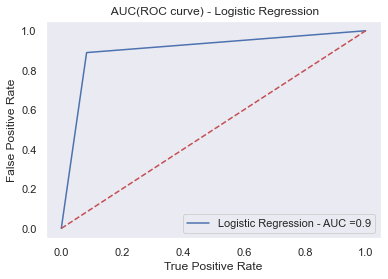

In [61]:
plot_roc_curve(y_test, bin_lr_pred, 'Logistic Regression')

## Decision Tree

In [62]:
bin_dt_clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=20, min_samples_split=30).fit(X_train_tf_bin, y_train)
bin_dt_pred = bin_dt_clf.predict(X_test_tf_bin)

print('Classification report:')
print(classification_report(y_test, bin_dt_pred))

bin_dt_scores = cross_val_score(bin_dt_clf, X_train_tf_bin, y_train, cv=10)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_dt_scores.mean(), bin_dt_scores.std()))

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79      1828
           1       0.98      0.89      0.94      7258

    accuracy                           0.90      9086
   macro avg       0.84      0.92      0.87      9086
weighted avg       0.92      0.90      0.91      9086


 
0.91 accuracy with a standard deviation of 0.01


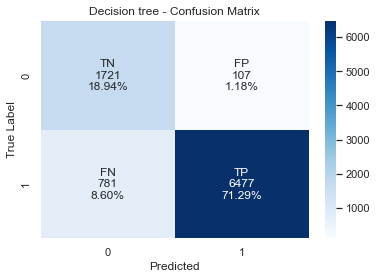

In [63]:
bin_dt_cm = confusion_matrix(y_test, bin_dt_pred)
make_confusion_matrix(bin_dt_cm, 'Decision tree - Confusion Matrix')

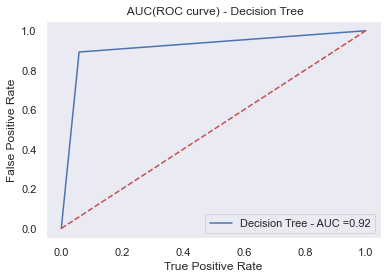

In [64]:
plot_roc_curve(y_test, bin_dt_pred, 'Decision Tree')

## Random Forest Classifier

Slower than the other classifiers, it guarantees the same accuracy (90%)

In [65]:
bin_rf_clf = RandomForestClassifier(min_samples_leaf=20, min_samples_split=30).fit(X_train_tf_bin, y_train)
bin_rf_pred = bin_rf_clf.predict(X_test_tf_bin)

print('Classification report:')
print(classification_report(y_test, bin_rf_pred))

bin_rf_scores = cross_val_score(bin_rf_clf, X_train_tf_bin, y_train, cv=10)
print("\n \n%0.2f accuracy with a standard deviation of %0.2f" % (bin_rf_scores.mean(), bin_rf_scores.std()))

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.93      0.77      1828
           1       0.98      0.88      0.93      7258

    accuracy                           0.89      9086
   macro avg       0.82      0.90      0.85      9086
weighted avg       0.91      0.89      0.90      9086


 
0.90 accuracy with a standard deviation of 0.01


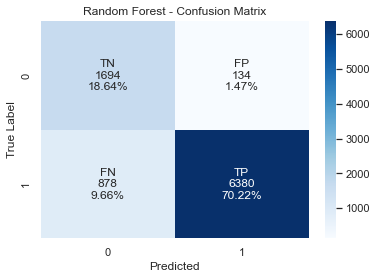

In [66]:
bin_rf_cm = confusion_matrix(y_test, bin_rf_pred)
make_confusion_matrix(bin_rf_cm, 'Random Forest - Confusion Matrix')

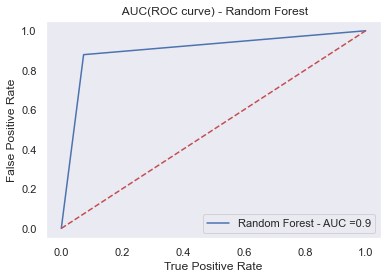

In [67]:
plot_roc_curve(y_test, bin_rf_pred, 'Random Forest')

In [68]:
df

,Tweet,cat_Type,Type,text_clean,Tweet_tokenized,tokenized_bigram,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,word katandandre food crapilicious mkr,"['word', 'katandandre', 'food', 'crapilicious'...","[('word', 'katandandre'), ('katandandre', 'foo...",9
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,aussietv white mkr theblock today sunrise stud...,"['aussietv', 'white', 'mkr', 'theblock', 'toda...","[('aussietv', 'white'), ('white', 'mkr'), ('mk...",14
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classy whore red velvet cupcake,"['classy', 'whore', 'red', 'velvet', 'cupcake']","[('classy', 'whore'), ('whore', 'red'), ('red'...",9
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,jasongio meh thanks head concern another angry...,"['jasongio', 'meh', 'thanks', 'head', 'concern...","[('jasongio', 'meh'), ('meh', 'thanks'), ('tha...",18
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,rudhoeenglish isis account pretend kurdish acc...,"['rudhoeenglish', 'isis', 'account', 'pretend'...","[('rudhoeenglish', 'isis'), ('isis', 'account'...",18
...,...,...,...,...,...,...,...
39396,@YourFavWhiteGuy shut the fuck upAbout your du...,ethnicity,1,shut fuck upabout dumb app act like nag nigger,"['shut', 'fuck', 'upabout', 'dumb', 'app', 'ac...","[('shut', 'fuck'), ('fuck', 'upabout'), ('upab...",15
39397,"Black ppl aren't expected to do anything, depe...",ethnicity,1,black arent expect anything depend anything ye...,"['black', 'arent', 'expect', 'anything', 'depe...","[('black', 'arent'), ('arent', 'expect'), ('ex...",42
39399,I swear to God. This dumb nigger bitch. I have...,ethnicity,1,swear god dumb nigger bitch get bleach hair re...,"['swear', 'god', 'dumb', 'nigger', 'bitch', 'g...","[('swear', 'god'), ('god', 'dumb'), ('dumb', '...",20
39400,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1,yea fuck therealexel you be nigger fuck unfoll...,"['yea', 'fuck', 'therealexel', 'you', 'be', 'n...","[('yea', 'fuck'), ('fuck', 'therealexel'), ('t...",15


## Calibration probabilities

In [69]:
from sklearn.calibration import CalibrationDisplay

In [70]:
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [71]:
# Create classifiers
lr = LogisticRegression(penalty='l2', solver = 'sag', C=0.5)
gnb = MultinomialNB()
svc = NaivelyCalibratedLinearSVC(C=0.5)
rfc = RandomForestClassifier(min_samples_leaf=20, min_samples_split=30)

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

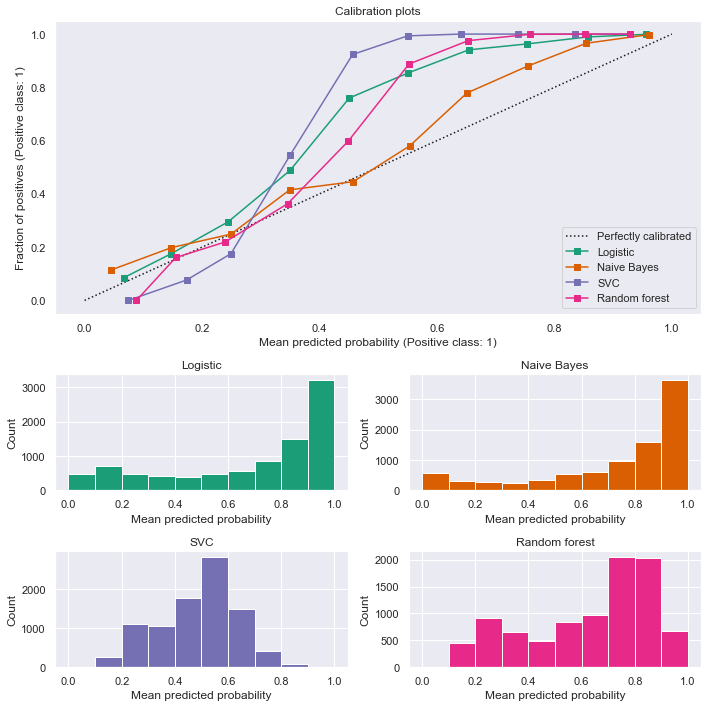

In [72]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_tf_bin, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_tf_bin,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Naive Bayes Explainability with LIME

In [73]:
## split to train and test
X_trainexp, X_val, y_trainexp, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 2000, analyzer = "word", ngram_range = (1, 2), lowercase = True)
train_vc = tfidf_vc.fit_transform(X_trainexp)
val_vc = tfidf_vc.transform(X_val)

In [74]:
model =MultinomialNB()
model = model.fit(train_vc, y_trainexp)
val_pred = model.predict(val_vc)

from sklearn.metrics import f1_score
val_cv = f1_score(y_val, val_pred, average = "binary")
print(val_cv)

0.8607656669105096


In [75]:
idx = 142
c = make_pipeline(tfidf_vc, model)
class_names = ["Not_cyberbullying", "Cyberbullying"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(X_val[idx], c.predict_proba , num_features = 10)

print("Question: \n", X_val[idx])
print("Probability (Cyberbullying) =", c.predict_proba([X_val[idx]])[0, 1])
print("Probability (Not_cyberbullying) =", c.predict_proba([X_val[idx]])[0, 0])
print("True Class is:", class_names[y_val[idx]])

Question: 
 ['guy', 'bully', 'girl', 'high', 'school', 'start', 'go', 'bald']
Probability (Cyberbullying) = 0.9764330350800375
Probability (Not_cyberbullying) = 0.023566964919961658
True Class is: Cyberbullying


In [76]:
exp.as_list()

[('high', 0.21684873973728352),
 ('girl', 0.12363921740853837),
 ('bully', 0.0835466491037994),
 ('school', 0.07300842631328483),
 ('start', -0.03939549089417604),
 ('go', -0.023253213448694528),
 ('guy', -0.0027205425486121555),
 ('bald', 0.00026704559936110186)]

In [77]:
X_val[idx]

"['guy', 'bully', 'girl', 'high', 'school', 'start', 'go', 'bald']"

In [78]:
exp.show_in_notebook(text = X_val[idx], labels=(1,))

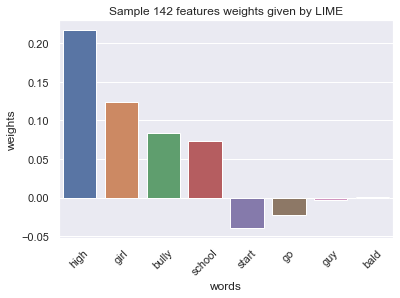

In [79]:
from collections import OrderedDict

weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(idx))
plt.show()